In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".1"

from jax import numpy as jnp
import jax
import temgymbasic.jax_components as comp
from temgymbasic.jax_run import run_to_end, run_to_component
from temgymbasic.jax_ray import Ray, propagate
from temgymbasic.jax_utils import get_pytree_idx_from_model
import matplotlib.pyplot as plt
%matplotlib widget

jax.config.update("jax_enable_x64", True)

In [ ]:
def find_pixels_within_semi_conv_from_pt_source(pixel_coords, scan_pos, semi_conv, transformation_matrix):
    """
    Given a set of pixel coordinates, a semi-convergence angle, and a transformation matrix, find all the pixels
    which will be lit up by a point source with the given semi-convergence angle.

    Args:
    - pixel_coords (jnp.array): A (N, 2) array of pixel coordinates.
    - scan_pos (jnp.array): A (2,) array of the scan position in x and y.
    - semi_conv (float): The semi-convergence angle of the point source.
    - transformation_matrix (jnp.array): A (5, 5) transformation matrix.
    """
    # We rely on the fact that u**2 + v**2 = semi_conv**2
    # For a point source, our system of equations is:
    # [x_out, y_out, theta_x_out, theta_y_out, 1] = transformation_matrix @ [scan_pos_x, scan_pos_y, u, v, 1]
    # where u and v are given by alpha * cos(theta) and alpha * sin(theta) respectively
    # representing the semi convergence angle and azimuthal angle of a ray from the point source
    # we can find an equation for u and v by simply solving the above equation for u and v.
    scan_pos_x, scan_pos_y = scan_pos
    A_xx, A_xy, B_xx, B_xy = transformation_matrix[0, :4]
    A_yx, A_yy, B_yx, B_yy = transformation_matrix[1, :4]
    delta_x, delta_y = transformation_matrix[0, 4], transformation_matrix[1, 4]
    x_out, y_out = pixel_coords[:, 0], pixel_coords[:, 1]

    denom = (B_xx*B_yy - B_xy*B_yx)
    u = (-A_xx*B_yy*scan_pos_x - A_xy*B_yy*scan_pos_y + A_yx*B_xy*scan_pos_x + 
         A_yy*B_xy*scan_pos_y + B_xy*delta_y - B_xy*y_out - B_yy*delta_x + B_yy*x_out) / denom
    v = (A_xx*B_yx*scan_pos_x + A_xy*B_yx*scan_pos_y - A_yx*B_xx*scan_pos_x - 
         A_yy*B_xx*scan_pos_y - B_xx*delta_y + B_xx*y_out + B_yx*delta_x - B_yx*x_out) / denom
    F = (u**2 + v**2) - semi_conv **2
    mask = F <= 0
    return pixel_coords[mask]

In [4]:
from scipy.ndimage import zoom

image = plt.imread('SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
image_shape = image.shape

# Downsample the image by a factor of 2
downsample_factor = 0.5
image = zoom(image, downsample_factor)
image_shape = image.shape


Modelling Descan Error: In order to determine how the descan error description should look like, I thought only about what basic operations a descanner should apply so that we have a 5x5 coordinate transform that is still invertible, and I used jax to find where the operations I apply would popualte the jacobian, which has helped me discover the following analysis. 

Importantly, even in the non-linear case (not yet demonstrated in this notebook but can be soon) we can always find a polynomial which we can then find roots of, that relate outgoing coordinates (positions and slopes), EXCEPT in certain circumstances like when a lens performs perfect imaging from the object plane to the image plane. In this case, there is no single angle that maps positions to positions. When certain coeffients in the polynomial description relating coordinates are zero, you will know you are in this regime, and there is no direct mapping. This is an advantage to this approach, that I don't see with an optimiser being sent at the model to find where rays go - with gradients in jax we will always be able to find a simpler polynomial we can find roots of (if certain terms exist) to tell us what angle ray will take us back to the input plane. 

All of this means that from my limited understanding so far I don't think an optimiser is entirely neccessary in the way it was implemented in pytorch: This does not mean I don't think an optimiser won't be needed to solve other parts of this problem, or be used in a different way, just strictly for ray tracing in this context: I will also write an optimiser and compare it to the ray gradient method to get coefficients! And we can compare both methods!

For now though here are the drawbacks, and why I went with this approach:

1: It won't understand if the setup of the system has a 1 to 1 mapping from input plane to output plane. With the transfer coefficients, if the terms B (see matrix below) are zero, we know we are in perfect imaging and no unique angle mapping from input plane to output plane exists.  

2: It won't understand if there are multiple solutions, where as with a polynomial description we know how many roots there are. 

3: One ray and it's gradients characterises the system and all it's coefficients each time. (It can even tell you the phase an amplitude of a local description around the wavefront (I am about to add this possibility))

With that noted here is the model we have for descan error:

The overall matrix description we aiming for is as follows: (whereby we did not restrict ourselves to writing matrices for each component to discover the terms in this matrix):


$\displaystyle 
\left(\begin{matrix} 
x_{out} \\[0.3em] 
y_{out} \\[0.3em] 
\theta_{x-out} \\[0.3em] 
\theta_{y-out} \\[0.3em]
1 
\end{matrix}\right)
\;=\;
\left(\begin{matrix} 
A_{xx} & A_{xy} & B_{xx} & B_{xy} & {\Delta}x \\[0.5em] 
A_{yx} & A_{yy} & B_{yx} & B_{yy} & {\Delta}y \\[0.5em] 
C_{xx} & C_{xy} & D_{xx} & D_{xy} & {\Delta}\theta_{x} \\[0.5em] 
C_{yx} & C_{yy} & D_{yx} & D_{yy} & {\Delta}\theta_{y} \\[0.5em] 
0      & 0      & 0      & 0      & 1 
\end{matrix}\right)
\left(\begin{matrix} 
x_{in} \\[0.3em] 
y_{in} \\[0.3em] 
\theta_{x-in} \\[0.3em] 
\theta_{y-in} \\[0.3em]
1 
\end{matrix}\right)$

For an ideal descanner to perform it's job, and have a matrix that is invertible I have come up with the following:

$\displaystyle 
\left(\begin{matrix} 
x_{out} \\[0.3em] 
y_{out} \\[0.3em] 
\theta_{x-out} \\[0.3em] 
\theta_{y-out} \\[0.3em]
1 
\end{matrix}\right)
\;=\;
\left(\begin{matrix} 
1 & 0 & 0 & 0 & {\Delta}scan-pos_x \\[0.5em]  
0 & 1 & 0 & 0 & {\Delta}scan-pos_y \\[0.5em]  
0 & 0 & 1 & 0 & 0 \\[0.5em]  
0 & 0 & 0 & 1 & 0 \\[0.5em]  
0 & 0 & 0 & 0 & 1
\end{matrix}\right)
\left(\begin{matrix} 
x_{in} \\[0.3em] 
y_{in} \\[0.3em] 
\theta_{x-in} \\[0.3em] 
\theta_{y-in} \\[0.3em]
1 
\end{matrix}\right)$

Where are the descan error terms in the matrix? 

Hidden in the Axx, Ayy and Cxx, Cyy positions: Axx and Ayy for descan position error, because they are the values 
that change outgoing position as a function of incoming position (A is actually the magnification value too in ABCD matrices). 

Cxx and Cyy because they are the values that affect outgoing angle as a function of incoming position.

$\displaystyle 
\left(\begin{matrix} 
x_{out} \\[0.3em] 
y_{out} \\[0.3em] 
\theta_{x-out} \\[0.3em] 
\theta_{y-out} \\[0.3em]
1 
\end{matrix}\right)
\;=\;
\left(\begin{matrix} 
DescanError \; pos_{xx} & DescanError \; pos_{xy} & 0 & 0 & {\Delta}scan-pos_x \\[0.5em]  
DescanError \; pos_{yx} & DescanError \; pos_{yy} & 0 & 0 & {\Delta}scan-pos_y \\[0.5em]  
DescanError \; \theta_{xx} & DescanError \; \theta_{xy} & 1 & 0 & 0 \\[0.5em]  
DescanError \; \theta_{yx} & DescanError \; \theta_{yy} & 0 & 1 & 0 \\[0.5em]  
0 & 0 & 0 & 0 & 1
\end{matrix}\right)
\left(\begin{matrix} 
x_{in} \\[0.3em] 
y_{in} \\[0.3em] 
\theta_{x-in} \\[0.3em] 
\theta_{y-in} \\[0.3em]
1 
\end{matrix}\right)$

The bad news is this matrix changes it's ${\Delta}scan-pos_x$ and $\Delta y_{scan-pos}$ values each time, but the internal 4x4 matrix values are constant. 

Of course if there are mixed errors then they show up as cross terms in the matrix, and if there are errors as a function of tilt, they occupy the B and D quadrants. 

Ultimately, I think that in the linear case this should be the transfer matrix one is trying to learn from the 4D stem dataset. 


In [5]:
# Linear Descan Error #1, 1, 0, 0 represents no descan tilt error in x, y, dx or dy. 
descan_error = [0.8, 1.0, 3, 0.0] # Ax, Ay, Cx, Cy - these are the coefficients which will eventually end up in this transfer matrix. 

#Set up some parameters for the simulation
defocus = 0.01
semi_conv = 0.025
camera_length = 1.0
scan_position = (0.004, 0.00)

image_pixel_size = 0.0001
det_pixel_size = 0.001

Create the model: Just 3 components: Sample, Descanner and Detector. For now we ignore the Scanner.

In [6]:
key = jax.random.PRNGKey(0)
complex_image = image + 1j * jax.random.normal(key, (image.shape))

#Create the model - just 3 components 
model = [comp.Sample(z=defocus, complex_image=complex_image, pixel_size=image_pixel_size),
         comp.Descanner(z=defocus, descan_error=descan_error, offset_x=scan_position[0], offset_y=scan_position[1]),
         comp.Detector(z=camera_length, pixel_size=det_pixel_size, shape=(image.shape))]

detector_coords = model[-1].get_coords()
sample_coords = model[0].get_coords()


Now we make a single ray and propagate it from the initial scan position to the detector. 

In [7]:
#Create ray input
crossover_z = jnp.zeros((1))
sample_z = jnp.ones((1)) * defocus

input_ray_positions = jnp.vstack([
    scan_position[0], # x
    scan_position[1], # y
    0, # dx
    0, # dy
    jnp.ones((1)).reshape(1)
]).T

input_amplitude = jnp.ones(1)
input_pathlength = jnp.zeros(1)
input_wavelength = jnp.ones(1)
input_blocked = jnp.zeros(1, dtype=float)

Rays = Ray(z=crossover_z, 
           matrix=input_ray_positions, 
           amplitude=input_amplitude, 
           pathlength=input_pathlength, 
           wavelength=input_wavelength,
           blocked=input_blocked)

# Set up the function to calculate the jacobian after propagation from one component to another
# We can run multiple rays if we want, but no need for now. 
jac_run_to_component = jax.vmap(jax.jacobian(run_to_component), in_axes=(0, None))

single_ray_out = run_to_end(Rays, model)

jacobians_comp_to_comp = []

# Get all jacobians from one component to another
for i in range(len(model)):
    if i == 0:
        ray = Rays
    else:
        distance = (model[i-1].z - ray.z).squeeze()
        ray = propagate(distance, ray)
        ray = model[i-1].step(ray)
    
    jacobian = jac_run_to_component(ray, model[i])
    jacobians_comp_to_comp.append({
        'component_name': type(model[i]).__name__,
        'jacobian': jacobian
    })

Now we display the jacobians from one plane to another: 

**Note:** there is one small extra trick to fill in the final column of the matrix as the partial derivative of a constant is 0, so the jacobian will not tell us the shift or tilt delta that was applied by the decsanner. We are storing those values in the path length function of the descanner, which is a bit of a fudge for now: Ultimately, all of the terms in the coordinate transform should actually be calculated by differentiating an optical path length function, because the optical path length is the generating function behind the coordinate transform (It is to do with the optical path length representing the lagrangian of the system). For now though to keep it simple I just use optical path length to store shift and tilt deltas.

In [8]:
forward_ABCDs_comp_to_comp = []
inverse_ABCDs_comp_to_comp = []
total_forward = jnp.eye(5)
total_inverse = jnp.eye(5)

identity = jnp.eye(5)
for entry in jacobians_comp_to_comp:
    comp_name = entry['component_name']
    ray_jacobian = entry['jacobian'] #dr_out/dr_in
    shift_vectors = ray_jacobian.pathlength.matrix # This is the shift vector for each ray, dopl_out/dr_in
    ABCD = ray_jacobian.matrix.matrix
    ABCD = ABCD.at[0, :, -1].set(shift_vectors[0, :])
    ABCD = ABCD.at[0, -1, -1].set(1.0)
    print('Component:', comp_name)
    print('\n Forward Coordinate Transform = \n', ABCD)
    forward_ABCDs_comp_to_comp.append(ABCD)
    inverse_ABCD = jnp.linalg.solve(ABCD, identity)
    print('Inverse Coordinate Transform = \n', inverse_ABCD, '\n')
    inverse_ABCDs_comp_to_comp.append(inverse_ABCD)
    total_forward = ABCD @ total_forward
    print('Total Forward = \n', total_forward)
    total_inverse = inverse_ABCD @ total_inverse


matrix_crossover_to_sample = forward_ABCDs_comp_to_comp[0]
matrix_sample_to_detector = forward_ABCDs_comp_to_comp[2] @ forward_ABCDs_comp_to_comp[1]
matrix_crossover_to_detector = matrix_sample_to_detector @ forward_ABCDs_comp_to_comp[0]
matrix_detector_to_sample = jnp.linalg.solve(matrix_sample_to_detector, identity)
print('Sample to Detector = \n', matrix_sample_to_detector)
print('Detector to Sample= ', matrix_detector_to_sample)


Component: Sample

 Forward Coordinate Transform = 
 [[[1.   0.   0.01 0.   0.  ]
  [0.   1.   0.   0.01 0.  ]
  [0.   0.   1.   0.   0.  ]
  [0.   0.   0.   1.   0.  ]
  [0.   0.   0.   0.   1.  ]]]
Inverse Coordinate Transform = 
 [[[ 1.    0.   -0.01  0.    0.  ]
  [ 0.    1.    0.   -0.01  0.  ]
  [ 0.    0.    1.    0.    0.  ]
  [ 0.    0.    0.    1.    0.  ]
  [ 0.    0.    0.    0.    1.  ]]] 

Total Forward = 
 [[[1.   0.   0.01 0.   0.  ]
  [0.   1.   0.   0.01 0.  ]
  [0.   0.   1.   0.   0.  ]
  [0.   0.   0.   1.   0.  ]
  [0.   0.   0.   0.   1.  ]]]
Component: Descanner

 Forward Coordinate Transform = 
 [[[ 0.8    0.     0.     0.    -0.004]
  [ 0.     1.     0.     0.     0.   ]
  [ 3.     0.     1.     0.     0.   ]
  [ 0.     0.     0.     1.     0.   ]
  [ 0.     0.     0.     0.     1.   ]]]
Inverse Coordinate Transform = 
 [[[ 1.25   0.     0.     0.     0.005]
  [ 0.     1.     0.     0.     0.   ]
  [-3.75  -0.     1.    -0.    -0.015]
  [ 0.     0.     0.     

It's interesting to note that the final transfer matrix from crossover is not entirely what one would expect. The terms mix and give something that is harder to reason about, but it is still invertible. 

Now we are going to display some of the expressions that allow us to go back and forth between detector and crossover, or we could also do detector and sample. Even for higher order terms, we can always get these expressions that normally go from one aperture to another.

In [9]:
import sympy as sp

x_in, y_in, theta_x_in, theta_y_in = sp.symbols('x_in y_in theta_x_in theta_y_in')
x_out, y_out, theta_x_out, theta_y_out = sp.symbols('x_out y_out theta_x_out theta_y_out')

in_coords = sp.Matrix([x_in, y_in, theta_x_in, theta_y_in, 1])
out_coords = sp.Matrix([x_out, y_out, theta_x_out, theta_y_out, 1])

in_coords_expr = sp.Eq(in_coords, sp.Matrix(total_inverse[0]) @ out_coords)
out_coords_expr = sp.Eq(out_coords, sp.Matrix(total_forward[0]) @ in_coords)

x_in_expr = sp.Eq(in_coords_expr.lhs[0], in_coords_expr.rhs[0])
y_in_expr = sp.Eq(in_coords_expr.lhs[1], in_coords_expr.rhs[1])
theta_x_in_expr = sp.Eq(in_coords_expr.lhs[2], in_coords_expr.rhs[2])
theta_y_in_expr = sp.Eq(in_coords_expr.lhs[3], in_coords_expr.rhs[3])

x_out_expr = sp.Eq(out_coords_expr.lhs[0], out_coords_expr.rhs[0])
y_out_expr = sp.Eq(out_coords_expr.lhs[1], out_coords_expr.rhs[1])
theta_x_out_expr = sp.Eq(out_coords_expr.lhs[2], out_coords_expr.rhs[2])
theta_y_out_expr = sp.Eq(out_coords_expr.lhs[3], out_coords_expr.rhs[3])

theta_y_out_as_f_of_ys = sp.solve(y_in_expr, theta_y_out)[0]
theta_x_out_as_f_of_xs = sp.solve(x_in_expr, theta_x_out)[0]
theta_y_in_as_f_of_ys = sp.solve(y_out_expr, theta_y_in)[0]
theta_x_in_as_f_of_xs = sp.solve(x_out_expr, theta_x_in)[0]

display(x_in_expr)
display(y_in_expr)
display(theta_x_in_expr)
display(theta_y_in_expr)

display(x_out_expr)
display(y_out_expr)
display(theta_x_out_expr)
display(theta_y_out_expr)

theta_x_out_as_f_of_xs_lam = sp.lambdify((x_in, x_out), theta_x_out_as_f_of_xs)
theta_y_out_as_f_of_ys_lam = sp.lambdify((y_in, y_out), theta_y_out_as_f_of_ys)

theta_x_in_as_f_of_xs_lam = sp.lambdify((x_in, x_out), theta_x_in_as_f_of_xs)
theta_y_in_as_f_of_ys_lam = sp.lambdify((y_in, y_out), theta_y_in_as_f_of_ys)

det_coords_x = detector_coords[:, 0]
det_coords_y = detector_coords[:, 1]

sample_coords_x = sample_coords[:, 0]
sample_coords_y = sample_coords[:, 1]

num_points = 100
num_radial = 20  # number of radial layers
radii = jnp.linspace(0, semi_conv, num_radial)
angles = jnp.linspace(0, 2*jnp.pi, num_points)
R, A = jnp.meshgrid(radii, angles, indexing='ij')
Theta_X = (R * jnp.cos(A)).ravel()
Theta_Y = (R * jnp.sin(A)).ravel()

rays_at_source_with_semi_conv = jnp.vstack([
    jnp.full(len(Theta_X.ravel()), scan_position[0]),
    jnp.full(len(Theta_X.ravel()), scan_position[1]),
    Theta_X.ravel(),
    Theta_Y.ravel(),
    jnp.ones_like(Theta_X.ravel())
])



Eq(x_in, -1.039625*theta_x_out + 4.9625*x_out + 0.0316103532850441)

Eq(y_in, -1.0*theta_y_out + 1.0*y_out)

Eq(theta_x_in, 1.0375*theta_x_out - 3.75*x_out - 0.0268791447323678)

Eq(theta_y_in, 1.0*theta_y_out)

Eq(x_out, 1.0277*theta_x_in + 3.77*x_in - 0.004)

Eq(y_out, 1.0*theta_y_in + 1.0*y_in)

Eq(theta_x_out, 1.03*theta_x_in + 3.0*x_in + 0.0118791447323678)

Eq(theta_y_out, 1.0*theta_y_in)

Finally we just visualise how this descan error matrix looks in the system: 

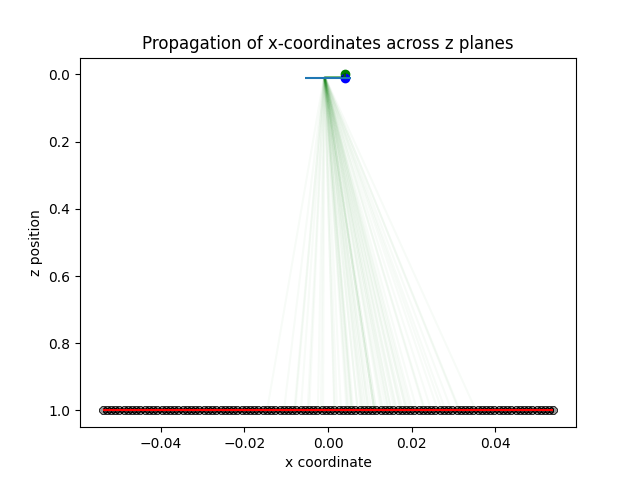

In [10]:
# Build an array of z positions: the first layer from crossover_z and then each component's z field
zs = jnp.array([crossover_z[0]] + [comp.z for comp in model])

# Propagate the point source coordinates through the forward ABCD matrices
coord_list = [rays_at_source_with_semi_conv]
for forward_ABCD in forward_ABCDs_comp_to_comp:
    new_coord = jnp.dot(forward_ABCD[0], coord_list[-1])
    coord_list.append(new_coord)
    
# Stack the propagated coordinates into an array for easier indexing
coords_array = jnp.stack(coord_list, axis=0)
xs = coords_array[:, 0, :]
ys = coords_array[:, 1, :]
num_rays = xs.shape[1]

plt.figure()
for ray in range(0, num_rays, 30):
    plt.plot(xs[:, ray], zs, color = 'g', alpha=0.03)

plt.hlines(zs[-1], detector_coords[0, 0], detector_coords[-1, 0], color='r', label='Detector')
plt.hlines(zs[1], sample_coords[0, 0], sample_coords[-1, 0])
plt.scatter(detector_coords[:, 0], jnp.full(detector_coords[:, 0].shape, zs[-1]), 
            color='k', 
            label='Detector Pixels',
            alpha=0.005)
plt.scatter(scan_position[0], crossover_z, color='g', label='Crossover')
plt.scatter(scan_position[0], defocus, color='b', label='Sample')

plt.xlabel('x coordinate')
plt.ylabel('z position')
plt.title('Propagation of x-coordinates across z planes')
plt.gca().invert_yaxis()  # Invert the z-axis (display)
plt.show()


In [11]:
semi_conv = 0.04
scan_position_x, scan_position_y = 0.004, 0.000
radius = semi_conv * defocus

mask = (sample_coords_x - scan_position_x) ** 2 + (sample_coords_y - scan_position_y) ** 2 < radius ** 2
sample_coords_x_circ = sample_coords_x[mask]
sample_coords_y_circ = sample_coords_y[mask]
sample_coords_r_circ = jnp.sqrt(sample_coords_x_circ ** 2 + sample_coords_y_circ ** 2)

# Compute the radial slope magnitudes using the small angle approximation.
init_slopes = sample_coords_r_circ / defocus
angles_circ = jnp.arctan2(sample_coords_y_circ, sample_coords_x_circ)
x_slopes = init_slopes * jnp.cos(angles_circ)
y_slopes = init_slopes * jnp.sin(angles_circ)

rays_at_sample_with_slope_from_crossover = jnp.vstack([
    jnp.full(len(sample_coords_x_circ), scan_position_x),
    jnp.full(len(sample_coords_y_circ), scan_position_y),
    x_slopes,
    y_slopes,
    jnp.ones_like(x_slopes)
])

rays_at_det = jnp.dot(matrix_crossover_to_detector[0], rays_at_sample_with_slope_from_crossover)

# import numpy as np
from jax.scipy.interpolate import RegularGridInterpolator
x = jnp.arange(image_shape[0])
y = jnp.arange(image_shape[1])
image_interpolant = RegularGridInterpolator((x, y), image)

sample_pixel_xs = (xs[1] / image_pixel_size) + image_shape[1] // 2
sample_pixel_ys = (ys[1] / image_pixel_size) + image_shape[0] // 2
# Combine the pixel coordinates into a single array (each row is [y, x])
sample_pts = jnp.stack([sample_pixel_ys, sample_pixel_xs], axis=-1)
sample_px_hit_by_rays = image_interpolant(sample_pts, method='linear')

detector_pixel_xs = (xs[-1, :] / det_pixel_size).astype(int) + image_shape[1] // 2
detector_pixel_ys = (ys[-1, :] / det_pixel_size).astype(int) + image_shape[0] // 2

detector_image = jnp.zeros((image.shape[0], image.shape[1]))
detector_image = detector_image.at[(detector_pixel_ys, detector_pixel_xs)].set(sample_px_hit_by_rays)

In [9]:
x_out, y_out, theta_x_out, theta_y_out = sp.symbols('x_out y_out theta_x_out theta_y_out')
x_in, y_in, theta_x_in, theta_y_in = sp.symbols('x_in y_in theta_x_in theta_y_in')

# Lit pixels from Point Source
# Make a 5x5 matrix for use in sympy with Axx, Axy, Ayx, Ayy, Bxx, Bxy, Byx, Byy... etc values in each quadrant
A_xx, A_xy, A_yx, A_yy = sp.symbols('A_xx A_xy A_yx A_yy', real=True)
B_xx, B_xy, B_yx, B_yy = sp.symbols('B_xx B_xy B_yx B_yy', real=True)
C_xx, C_xy, C_yx, C_yy = sp.symbols('C_xx C_xy C_yx C_yy', real=True)
D_xx, D_xy, D_yx, D_yy = sp.symbols('D_xx D_xy D_yx D_yy', real=True)
delta_x, delta_y, delta_theta_x, delta_theta_y = sp.symbols('delta_x delta_y delta_theta_x delta_theta_y', real=True)

#Populate the 5x5 matrix with the these symbols, with 0s in the bottom row, and 1 in the bottom right corner
TransferMatrix = sp.Matrix([[A_xx, A_xy, B_xx, B_xy, delta_x],
                            [A_yx, A_yy, B_yx, B_yy, delta_y],
                            [C_xx, C_xy, D_xx, D_xy, delta_theta_x],
                            [C_yx, C_yy, D_yx, D_yy, delta_theta_y],
                            [0, 0, 0, 0, 1]])

# create column vector of output coordinates, x_out, y_out, theta_x_out, theta_y_out 1
out_coords = sp.Matrix([x_out, y_out, theta_x_out, theta_y_out, 1])
semi_conv, phi = sp.symbols(r'\alpha, \phi')

#Now for the incoordinates, I want the vector to be populated via the following:
# x_in = scan_pos_x, y_in = scan_pos_y, but theta_x_in and theta_y_in should be a function to define a cone of rays 
# with a semi-convergence angle.
theta_x_in = semi_conv * sp.cos(phi)
theta_y_in = semi_conv * sp.sin(phi)
scan_position_x, scan_position_y = sp.symbols('scan_{x} scan_{y}')

in_coords = sp.Matrix([scan_position_x, scan_position_y, theta_x_in, theta_y_in, 1])
transfer_equation = sp.Eq(out_coords, TransferMatrix * in_coords, evaluate=False)
# reverse_equation = sp.Eq(in_coords, InvertedTransferMatrix * out_coords, evaluate=False)

x_out_eq = sp.Eq(out_coords[0], transfer_equation.rhs[0])
y_out_eq = sp.Eq(out_coords[1], transfer_equation.rhs[1])
theta_x_out_eq = sp.Eq(out_coords[2], transfer_equation.rhs[2])
theta_y_out_eq = sp.Eq(out_coords[3], transfer_equation.rhs[3])

display(transfer_equation)
display(x_out_eq)
display(y_out_eq)
display(theta_x_out_eq)
display(theta_y_out_eq)

#replace alpha * cos(phi) with u and alpha * sin(phi) with v, and use both equations to solve for u and v
u, v = sp.symbols('u v')
x_out_eq = x_out_eq.subs({theta_x_in: u, theta_y_in: v})
y_out_eq = y_out_eq.subs({theta_x_in: u, theta_y_in: v})

u_v_eq = sp.solve([x_out_eq, y_out_eq], [u, v])
print(u_v_eq[u])
print(u_v_eq[v])

⎡ xₒᵤₜ  ⎤   ⎡   Aₓₓ⋅scan_{x} + A_xy⋅scan_{y} + Bₓₓ⋅\alpha⋅cos(\phi) + B_xy⋅\al ↪
⎢       ⎥   ⎢                                                                  ↪
⎢ yₒᵤₜ  ⎥   ⎢ A_yx⋅scan_{x} + A_yy⋅scan_{y} + B_yx⋅\alpha⋅cos(\phi) + B_yy⋅\al ↪
⎢       ⎥   ⎢                                                                  ↪
⎢θₓ ₒᵤₜ ⎥ = ⎢Cₓₓ⋅scan_{x} + C_xy⋅scan_{y} + Dₓₓ⋅\alpha⋅cos(\phi) + D_xy⋅\alpha ↪
⎢       ⎥   ⎢                                                                  ↪
⎢θ_y_out⎥   ⎢C_yx⋅scan_{x} + C_yy⋅scan_{y} + D_yx⋅\alpha⋅cos(\phi) + D_yy⋅\alp ↪
⎢       ⎥   ⎢                                                                  ↪
⎣   1   ⎦   ⎣                                          1                       ↪

↪ pha⋅sin(\phi) + δₓ   ⎤
↪                      ⎥
↪ pha⋅sin(\phi) + δ_y  ⎥
↪                      ⎥
↪ ⋅sin(\phi) + δₜₕₑₜₐ ₓ⎥
↪                      ⎥
↪ ha⋅sin(\phi) + δ_θ_y ⎥
↪                      ⎥
↪                      ⎦

(-A_xx*B_yy*scan_{x} - A_xy*B_yy*scan_{y} + A_yx*B_xy*scan_{x} + A_yy*B_xy*scan_{y} + B_xy*delta_y - B_xy*y_out - B_yy*delta_x + B_yy*x_out)/(B_xx*B_yy - B_xy*B_yx)
(A_xx*B_yx*scan_{x} + A_xy*B_yx*scan_{y} - A_yx*B_xx*scan_{x} - A_yy*B_xx*scan_{y} - B_xx*delta_y + B_xx*y_out + B_yx*delta_x - B_yx*x_out)/(B_xx*B_yy - B_xy*B_yx)


In [2]:
import sympy as sp

# Enable pretty printing
sp.init_printing()

# Define symbols for a 5x5 matrix
a11, a12, a13, a14, a15 = sp.symbols('a11 a12 a13 a14 a15')
a21, a22, a23, a24, a25 = sp.symbols('a21 a22 a23 a24 a25')
a31, a32, a33, a34, a35 = sp.symbols('a31 a32 a33 a34 a35')
a41, a42, a43, a44, a45 = sp.symbols('a41 a42 a43 a44 a45')
a51, a52, a53, a54, a55 = sp.symbols('a51 a52 a53 a54 a55')

# Construct the 5x5 matrix
M = sp.Matrix([
    [a11, a12, a13, a14, a15],
    [a21, a22, a23, a24, a25],
    [a31, a32, a33, a34, a35],
    [a41, a42, a43, a44, a45],
    [a51, a52, a53, a54, a55]
])

# Compute the determinant of M
det_M = sp.symbols('det_M')
print("Determinant of M:")
display(det_M)
print("\n")

# Compute the adjugate of M (the transposed cofactor matrix)
adj_M = M.adjugate()
print("Adjugate (adjoint) of M:")
display(adj_M)
print("\n")

# Compute the inverse of M (provided det_M is nonzero)
M_inv = sp.simplify(adj_M / det_M)
print("Inverse of M:")
display(M_inv)


Determinant of M:




Adjugate (adjoint) of M:


⎡-a₂₂⋅(-a₃₃⋅(a₄₄⋅a₅₅ - a₄₅⋅a₅₄) - a₃₄⋅(a₄₃⋅a₄₄ + a₄₅⋅a₅₃) - a₃₅⋅(a₄₃⋅a₅₄ + a₅₃ ↪
⎢                                                                              ↪
⎢a₂₁⋅(-a₃₃⋅(a₄₄⋅a₅₅ - a₄₅⋅a₅₄) - a₃₄⋅(a₄₃⋅a₄₄ + a₄₅⋅a₅₃) - a₃₅⋅(a₄₃⋅a₅₄ + a₅₃⋅ ↪
⎢                                                                              ↪
⎢-a₂₁⋅(-a₃₂⋅(a₄₄⋅a₅₅ - a₄₅⋅a₅₄) - a₃₄⋅(a₄₂⋅a₄₄ + a₄₅⋅a₅₂) - a₃₅⋅(a₄₂⋅a₅₄ + a₅₂ ↪
⎢                                                                              ↪
⎢a₂₁⋅(-a₃₂⋅(a₄₃⋅a₅₅ - a₄₅⋅a₅₃) - a₃₃⋅(a₄₂⋅a₄₃ + a₄₅⋅a₅₂) - a₃₅⋅(a₄₂⋅a₅₃ + a₅₂⋅ ↪
⎢                                                                              ↪
⎣-a₂₁⋅(-a₃₂⋅(a₄₃⋅a₅₄ - a₄₄⋅a₅₃) - a₃₃⋅(a₄₂⋅a₄₃ + a₄₄⋅a₅₂) - a₃₄⋅(a₄₂⋅a₅₃ + a₅₂ ↪

↪ ⋅a₅₅) + (-a₄₄ - a₅₅)⋅(-a₃₄⋅a₄₃ - a₃₅⋅a₅₃)) - a₂₃⋅(a₃₃⋅(a₃₂⋅a₃₃ + a₃₄⋅a₄₂ + a ↪
↪                                                                              ↪
↪ a₅₅) + (-a₄₄ - a₅₅)⋅(-a₃₄⋅a₄₃ - a₃₅⋅a₅₃)) + a₂₃⋅(a₃₃⋅(a₃₁⋅a₃₃ + a₃₄⋅a₄₁ + a₃ ↪
↪                          



Inverse of M:


⎡a₂₂⋅a₃₃⋅a₄₄⋅a₅₅ - a₂₂⋅a₃₃⋅a₄₅⋅a₅₄ - a₂₂⋅a₃₄⋅a₄₃⋅a₅₅ + a₂₂⋅a₃₄⋅a₄₅⋅a₅₃ + a₂₂⋅a ↪
⎢───────────────────────────────────────────────────────────────────────────── ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢-a₂₁⋅a₃₃⋅a₄₄⋅a₅₅ + a₂₁⋅a₃₃⋅a₄₅⋅a₅₄ + a₂₁⋅a₃₄⋅a₄₃⋅a₅₅ - a₂₁⋅a₃₄⋅a₄₅⋅a₅₃ - a₂₁⋅ ↪
⎢───────────────────────────────────────────────────────────────────────────── ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢a₂₁⋅a₃₂⋅a₄₄⋅a₅₅ - a₂₁⋅a₃₂⋅a₄₅⋅a₅₄ - a₂₁⋅a₃₄⋅a₄₂⋅a₅₅ + a₂₁⋅a₃₄⋅a₄₅⋅a₅₂ + a₂₁⋅a ↪
⎢───────────────────────────────────────────────────────────────────────────── ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢-a₂₁⋅a₃₂⋅a₄₃⋅a₅₅ + a₂₁⋅a₃₂⋅

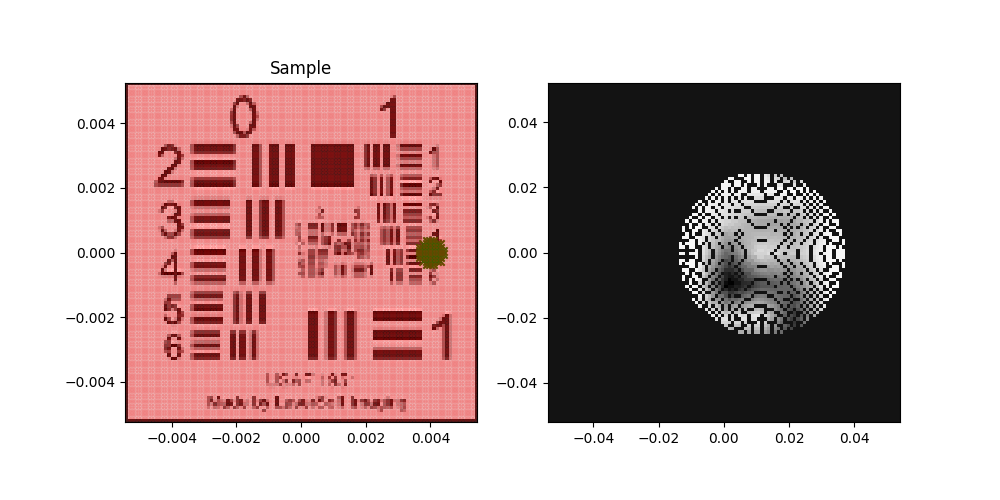

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray', extent=[sample_coords_x[0] - image_pixel_size / 2, sample_coords_x[-1] + image_pixel_size / 2, sample_coords_y[0] - image_pixel_size / 2, sample_coords_y[-1] + image_pixel_size / 2])
ax[0].scatter(sample_coords_x_circ, sample_coords_y_circ, c='g', marker='x', alpha=1)
ax[0].scatter(sample_coords_x, sample_coords_y, c='r', marker='x', alpha=0.1)
ax[0].set_title('Sample')
ax[1].imshow(detector_image, cmap='gray', extent=[-(image_shape[1] * det_pixel_size) / 2, (image_shape[1] * det_pixel_size) / 2, -(image_shape[0] * det_pixel_size) / 2, (image_shape[0] * det_pixel_size) / 2])
# ax[1].scatter(xs[-1], ys[-1], c='g', marker='x', alpha=0.01)
# ax[1].axhline(0, color='lightgrey', linestyle='--')
# ax[1].axvline(0, color='lightgrey', linestyle='--')
# ax[1].set_title('Detector Image')